# Twitter - Stocks EDA

## Objective

Perform Exploratory Data Analysis gain a deep understanding of data collected and infer intresting relationships between different features.

Here are few questions I would like to answer through this analysis:

1. Who are the top tweeters that tweet about stock market Check for top 15.
2. Are the tweets relaible. Who are they.
3. Is there any corelation between stock price and sentiment score
4. On large scale, How is the sentiment score fluctuating between price
5. How is the sentiment data distributed? Which stocks have best sentiment scores
6. Tweet Frequency can be a good score to judge popularity of a stock. Lets visualize popularity of each stock.
7. Check out which are most popular hashtags used for negative and postive sentiment associated with stocks

## Initialization and Loading Data

In [61]:
%matplotlib inline

import pandas as pd
from dateutil import parser
import datetime
import time


import matplotlib.pyplot as plt
import matplotlib.dates  as mdates
import matplotlib.colors as colors
import matplotlib.cm as cmx

import numpy as np
import warnings
warnings.filterwarnings("ignore")

import sqlite3
conn = sqlite3.connect("CMPT733.db")
c = conn.cursor()

# Reddit Specific Data Set
twitter_df = pd.read_sql("SELECT * FROM TBStocksTweets", conn)
twitter_df['created_utc'] = pd.to_datetime(twitter_df['created_utc'],infer_datetime_format=True)

# Complete Dataset
stocks_df = pd.read_json('processed_stocks.json')
stocks_df['created_utc'] = pd.to_datetime(stocks_df['created_utc']).dt.tz_localize(None)

b = pd.DataFrame(twitter_df[~twitter_df.hashtags.isna()].hashtags.str.lower().str.split(' ').tolist(), index=twitter_df[~twitter_df.hashtags.isna()].hashtags).stack()
b = b.reset_index()[[0, 'hashtags']] # var1 variable is currently labeled 0
b.columns = ['hashtag', 'hashtags']
exploded_df = pd.merge(twitter_df,b, how='inner',on=['hashtags','hashtags'])



### Quick View Twitter Data

In [170]:
exploded_df.head(3)

,index,asset_name,username,created_utc,retweets,favorites,text,hashtags,compound,neg,neu,pos,hashtag
0,0,Microsoft Corporation,Microsoft Asia,2018-02-27 03:42:00,4,13,How #MSFT is contributing to #Taiwan 's ambiti...,#MSFT #Taiwan #energy,0.4767,0.0,0.807,0.193,#msft
1,0,Microsoft Corporation,Microsoft Asia,2018-02-27 03:42:00,4,13,How #MSFT is contributing to #Taiwan 's ambiti...,#MSFT #Taiwan #energy,0.4767,0.0,0.807,0.193,#taiwan
2,0,Microsoft Corporation,Microsoft Asia,2018-02-27 03:42:00,4,13,How #MSFT is contributing to #Taiwan 's ambiti...,#MSFT #Taiwan #energy,0.4767,0.0,0.807,0.193,#energy


### Finding top 15 Tweeters and Hashtags associated with tweets about Stocks

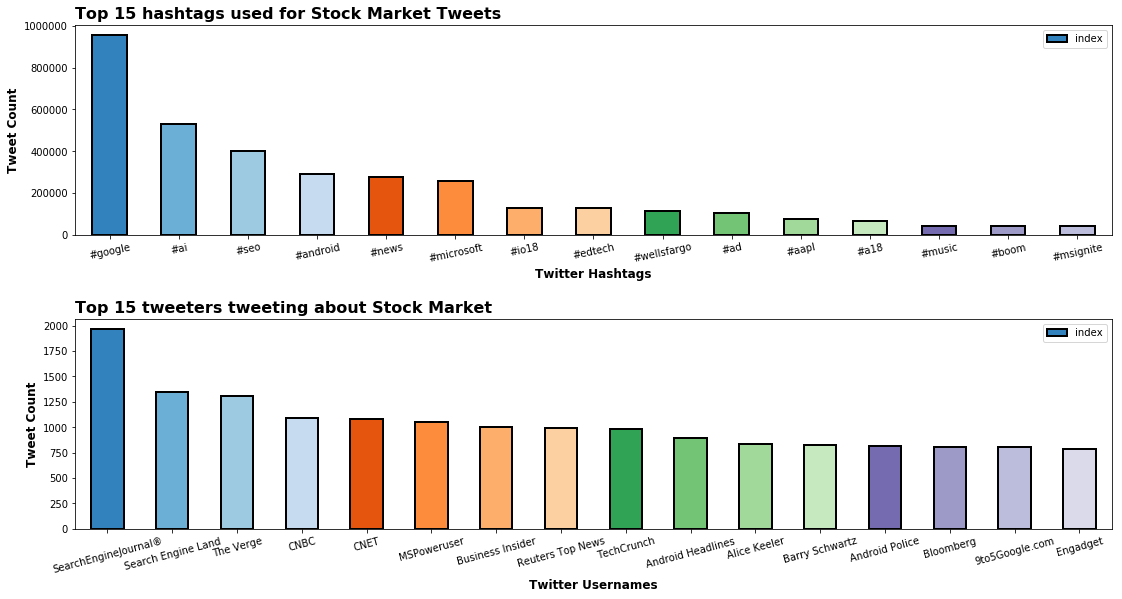

In [175]:
tweet_df = twitter_df.groupby('username').index.count()\
            .sort_values('index',ascending=False)\
            .head(16).reset_index()

fig,axlist =  plt.subplots(2, 1,figsize=(18,10))
hashtag_df = exploded_df.groupby('hashtag').index.count().reset_index().sort_values('index', ascending=False).head(17)
hashtag_df = hashtag_df[~hashtag_df.hashtag.isin(['#','#1'])]

axlist.flatten()[0].set_title('Top 15 hashtags used for Stock Market Tweets',\
                              fontweight="bold",loc='left',fontsize=16)
hashtag_df.plot.bar(x='hashtag', y='index', rot=12, ax= axlist.flatten()[0],\
                         color=plt.cm.tab20c(np.arange(len(hashtag_df))),edgecolor="black", lw=2)
axlist.flatten()[0].set_xlabel('Twitter Hashtags',fontweight="bold",fontsize=12)
axlist.flatten()[0].set_ylabel('Tweet Count',fontweight="bold",fontsize=12)
axlist.flatten()[1].set_title('Top 15 tweeters tweeting about Stock Market',\
                              fontweight="bold",loc='left',fontsize=16)

tweet_df.plot.bar(x='username', y='index', rot=15, ax= axlist.flatten()[1],\
                     color=plt.cm.tab20c(np.arange(len(tweet_df))), edgecolor="black", lw=2)
axlist.flatten()[1].set_xlabel('Twitter Usernames',fontweight="bold",fontsize=12)
axlist.flatten()[1].set_ylabel('Tweet Count',fontweight="bold",fontsize=12)
fig.subplots_adjust(top=0.9, left=0.1, right=0.9, bottom=0.20)
plt.subplots_adjust(hspace = 0.4 )


#### EDA Inference
From the above analysis we can tell that a good amount tweets were about google, android, AI and Microsoft. 
Also some of the tweeters that had tweeted the most are from news channels and agencies.
the above two pieces of information was used  to filter out spams and irrelavent tweets. 

## Get Sentiment Distribution for each Stock

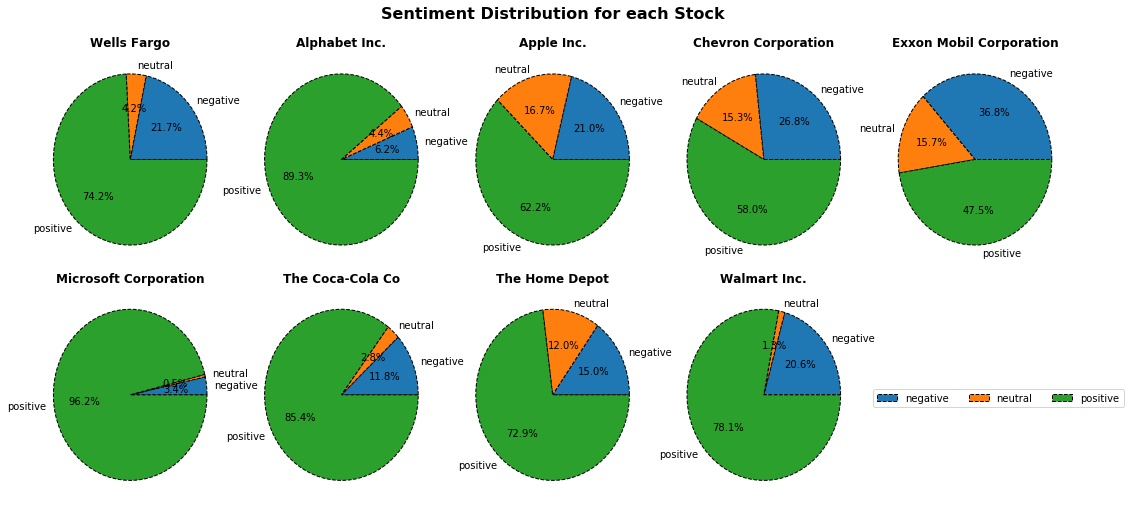

In [176]:
def set_sentiment(x):
    if x > 0: return 'positive'
    elif x == 0: return 'neutral'
    else: return 'negative'
stocks_df['len_tweet'] = stocks_df[stocks_df.tweet_text.notnull()].tweet_text.apply(lambda x: len(x))  
stocks_df['tweet_sentiment'] = stocks_df[stocks_df.tweet_compound.notnull()].tweet_compound.apply(lambda x: set_sentiment(x))   

tweet_count = stocks_df.groupby(['asset_name','tweet_sentiment']).len_tweet.count().reset_index()
coin = tweet_count['asset_name'].unique()

fig,axlist =  plt.subplots(2, 5,figsize=(18,8))
fig.suptitle('Sentiment Distribution for each Stock\n\n',fontweight="bold",fontsize=16)
i = 0
for ax in axlist.flatten():
    ax.set_title(coin[i-1],fontweight="bold",loc='center')
    fig.subplots_adjust(bottom=0.20)
    lns1 = ax.pie( 'len_tweet',labels='tweet_sentiment', autopct='%1.1f%%',\
          data=tweet_count[tweet_count['asset_name'] == coin[i-1]],\
         wedgeprops={"edgecolor":"k",'linewidth': 1, 'linestyle': 'dashed', 'antialiased': True})
    i = i + 1
    if i == 9:
        break;

fig.subplots_adjust(top=0.9, left=0.1, right=0.9, bottom=0.12)  # create some space below the plots by increasing the bottom-value
axlist.flatten()[9].set_axis_off()
axlist.flatten()[-2].legend(loc='upper right', bbox_to_anchor=(2.4, 0.55), ncol=3)

plt.subplots_adjust(hspace = 0.1,wspace = 0.1 )
plt.show()

#### EDA Inference

From the above pie charts we can see that the sentiment scores are satisfactorly distributed.
- Also we can tell that Microsoft followed by Alphabel have a good overall sentiment score among tweeters.
- Exxon Mobil followed by Chevron have the highest negative sentiment score among tweeters.

The negative sentiment about Exxon Mobil could be because of the bad press associated with it.

## Apple Inc. -  Extreme Sentiment Score Events VS Closing Price VS Time

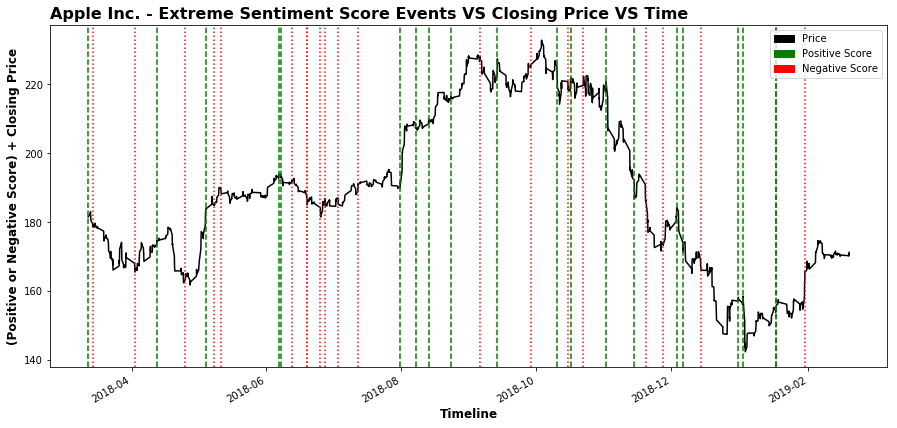

In [177]:
plot_1 = stocks_df[['asset_name','created_utc','tweet_compound','tweet_pos','tweet_retweets','tweet_neg','close']].sort_values('created_utc')
plot_1 = plot_1[plot_1.asset_name == 'Apple Inc.']
dF = plot_1.set_index('created_utc')
dF1 = dF.sort_values('tweet_compound', ascending = False).head(20)
dF2 = dF.sort_values('tweet_compound', ascending = True).head(20)
fig,axes = plt.subplots(figsize=(15,7))
axes.xaxis_date()
axes.plot(mdates.date2num(list(dF.index)),pd.Series.rolling(dF.close,2).mean(),color='black')
for xmaj in mdates.date2num(list(dF1.index)):
    axes.axvline(x=xmaj, ls='--', color='green')
for xmaj in mdates.date2num(list(dF2.index)):
    axes.axvline(x=xmaj, ls=':', color='red')
axes.set_title('Apple Inc. - Extreme Sentiment Score Events VS Closing Price VS Time',\
                              fontweight="bold",loc='left',fontsize=16)
axes.set_xlabel('Timeline',fontweight="bold",fontsize=12)
axes.set_ylabel('(Positive or Negative Score) + Closing Price',fontweight="bold",fontsize=12)

red_patch = mpatches.Patch(color='red', label='Negative Score')
green_patch = mpatches.Patch(color='green', label='Positive Score')
black_patch = mpatches.Patch(color='black', label='Price')

plt.legend(handles=[black_patch,green_patch,red_patch])
fig.autofmt_xdate()

#### EDA Inference

We can infer from the above time series chart, we can see some sort of relationship between the fluctuation of sentiment score with closing price. Now we want to test the reliability of our premise as well as the data itself.

**Premise: In an ideal senario, if the public opinion is bad or good, it should have some influence on the price in most cases. **

**Testing Procedure:** In order to prove the above statement, we have considered the most relavent tweets that have extreme cases of a sentiment score. Then we have plotted these events with the closing price of stocks. Lets see what the results where.

We can infer from the above time series chart, that the** price does fluctuate based on public opinion.**

## Stock VS Popularity

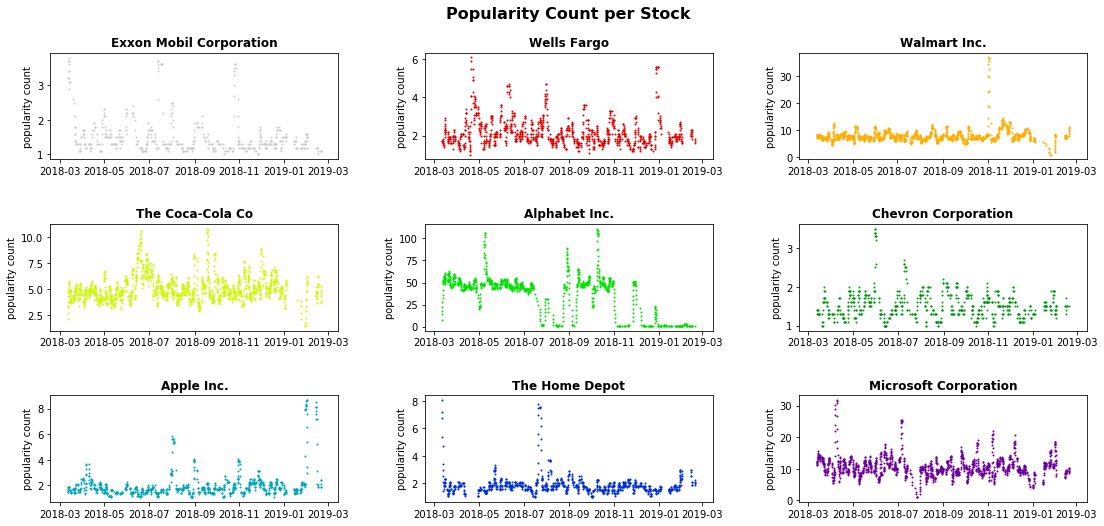

In [178]:
import matplotlib.colors as colors
import matplotlib.cm as cmx

fig,axlist =  plt.subplots(3, 3,figsize=(18,8))
fig.suptitle('Popularity Count per Stock\n\n',fontweight="bold",fontsize=16)


x=stocks_df[stocks_df.len_tweet>0].created_utc
y=pd.Series.rolling(stocks_df[stocks_df.len_tweet>0].len_tweet,10).mean()


# Get unique names of species
uniq = list(set(stocks_df['asset_name']))

# Set the color map to match the number of species
z = range(1,len(uniq))
hot = plt.get_cmap('nipy_spectral_r')
cNorm  = colors.Normalize(vmin=0, vmax=len(uniq))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=hot)

# 
i = 0
for ax in axlist.flatten():
    ax.set_title(uniq[i],fontweight="bold",loc='center')
    fig.subplots_adjust(bottom=0.20)
    indx = stocks_df['asset_name'] == uniq[i]
    ax.scatter(x[indx], y[indx],s=1, color=scalarMap.to_rgba(i), label=uniq[i])
    ax.set_ylabel('popularity count')
    i = i + 1
    if i == 9:
        break;

fig.subplots_adjust(top=0.9, left=0.1, right=0.9, bottom=0.12)  # create some space below the plots by increasing the bottom-value


plt.subplots_adjust(hspace = 0.6,wspace = 0.3 )
plt.show()


From the above graphs we can tell that Alphabet followed by Microsoft were the two most talked stocks among tweeters.
There is very less discussion happening about Exxon Mobil or Wells Fargo.

### Word Cloud : Hastags having the most impact

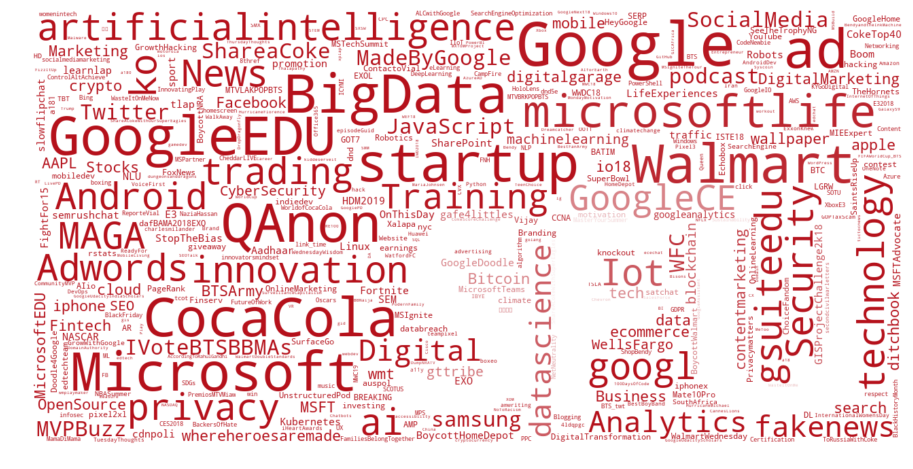

In [182]:


# modules for generating the word cloud
from os import path, getcwd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud, ImageColorGenerator

hashtag_df = result.groupby('hashtag').index.count().reset_index().sort_values('index', ascending=False)

d = getcwd()
## join all documents in corpus
h_df = hastag_df.head(500)
filtered_texts = h_df.hashtag.values
text = " ".join(filtered_texts)

mask = np.array(Image.open(path.join(d, "SFU.png")))
wc = WordCloud(background_color="white", max_words=1000, mask=mask,
               max_font_size=90, random_state=42)
wc.generate(text)
# create coloring from image
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[18,8])
plt.imshow(wc.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
_=plt.show()


### Most used Positive and Negative Hashtags for Stock related Tweets

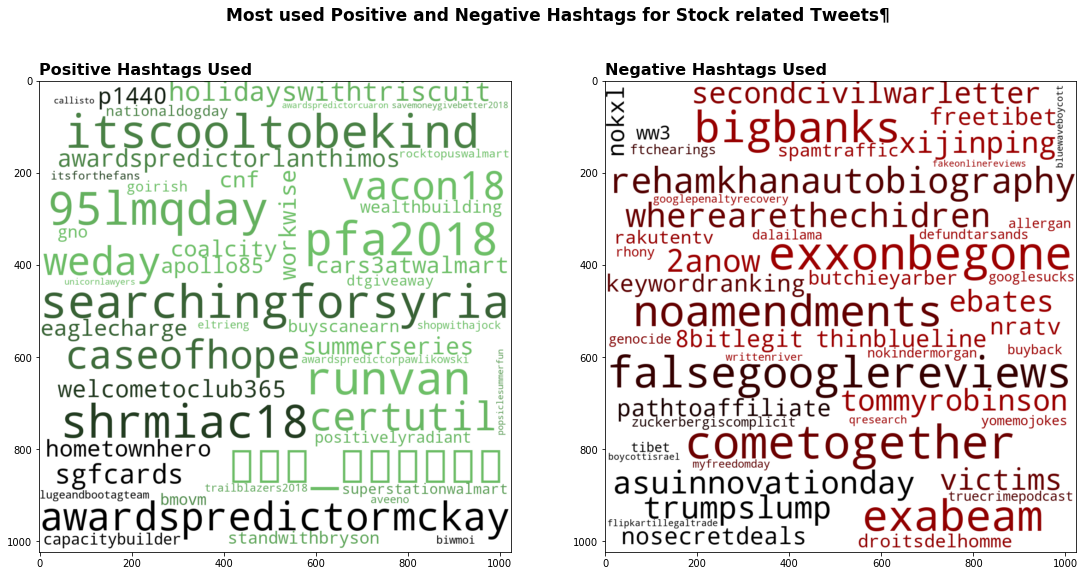

In [183]:
from os import path, getcwd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud, ImageColorGenerator

pos_df = exploded_df.groupby('hashtag').compound.mean().reset_index().sort_values('compound', ascending=False).head(10000)
pos_df_1 = exploded_df.groupby('hashtag').index.count().reset_index().sort_values('index', ascending=False).head(10000)
p_df = pd.merge(pos_df,pos_df_1, how='inner',on=['hashtag','hashtag']).head(100)

neg_df = exploded_df.groupby('hashtag').compound.mean().reset_index().sort_values('compound', ascending=True).head(10000)
n_df = pd.merge(neg_df,pos_df_1, how='inner',on=['hashtag','hashtag']).head(100)

fig,axlist =  plt.subplots(1, 2,figsize=(18,10))

d = getcwd()
## join all documents in corpus
filtered_texts = p_df.hashtag.values
text = " ".join(filtered_texts)
## image from PublicDomainPictures.net
## http://www.publicdomainpictures.net/view-image.php?image=232185&picture=family-gathering
mask = np.array(Image.open(path.join(d, "gcircle.png")))
wc = WordCloud(background_color="white", max_words=50, mask=mask,
               max_font_size=100, random_state=10)
wc.generate(text)
# create coloring from image
image_colors = ImageColorGenerator(mask)

axlist.flatten()[0].set_title('Positive Hashtags Used',\
                              fontweight="bold",loc='left',fontsize=16)
axlist.flatten()[0].imshow(wc.recolor(color_func=image_colors), interpolation="bilinear")


d = getcwd()
## join all documents in corpus
filtered_texts = n_df.hashtag.values
text = " ".join(filtered_texts)
## image from PublicDomainPictures.net
## http://www.publicdomainpictures.net/view-image.php?image=232185&picture=family-gathering
mask = np.array(Image.open(path.join(d, "circle.png")))
wc = WordCloud(background_color="white", max_words=50, mask=mask,
               max_font_size=100, random_state=10)
wc.generate(text)
# create coloring from image
image_colors = ImageColorGenerator(mask)


axlist.flatten()[1].set_title('Negative Hashtags Used',\
                              fontweight="bold",loc='left',fontsize=16)
axlist.flatten()[1].imshow(wc.recolor(color_func=image_colors), interpolation="bilinear")

fig.suptitle('Most used Positive and Negative Hashtags for Stock related Tweets¶\n\n',fontweight="bold",fontsize=17)
fig.subplots_adjust(top=0.9, left=0.1, right=0.9, bottom=0.20)
plt.subplots_adjust(hspace = 0.8 )